# Tel-Aviv Deep Learning Boot-camp: 12 Applied Deep Learning Labs


# Lab 3: ONNX, YOLO-3, Keras, Medical 3D visualization 


<img src="https://github.com/bayesianio/applied-dl-2018/raw/master/assets/tumor_visdom.jpg" align="center">

## Instructor:

- Shlomo Kashani: shlomo@deeponcology.ai


## Progress

- [x] Compile Darknet Yolo v3
- [x] Convert Darknet Yolo v3 to Keras v3
- []  Convert Keras to ONNX
- []  Convert Keras/ONNX to WebDNN


## Links:
- https://www.meetup.com/Tel-Aviv-Deep-Learning-Bootcamp/ 
- Git: https://github.com/bayesianio/applied-dl-2018
- Full info: https://www.evernote.com/shard/s341/sh/3855640e-2b0b-42e5-b5b9-00216d02ac9a/b47968226e49a81ee813901cd41d3924


## Google Colab version:


## Colab links:
- https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d
- https://jovianlin.io/pytorch-with-gpu-in-google-colab/

In [3]:
%reset -f 
%matplotlib inline

! pip install torch torchvision keras 

import matplotlib.pyplot as plt
import time
from shutil import copyfile
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import numpy as np
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as func
import torchvision
from torchvision import transforms, datasets, models
import random 


import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

use_cuda = torch.cuda.is_available()
# use_cuda = False

print("USE CUDA=" + str (use_cuda))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

manualSeed = 2222
def fixSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


if manualSeed is None:
        manualSeed = 999
fixSeed(manualSeed)

  Using cached https://files.pythonhosted.org/packages/69/43/380514bd9663f1bf708abeb359b8b48d3fabb1c8e95bb3427a980a064c57/torch-0.4.0-cp36-cp36m-manylinux1_x86_64.whl
tcmalloc: large alloc 1073750016 bytes == 0x5c26c000 @  0x7fb88dd501c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 2.2MB/s 
    100% |████████████████████████████████| 2.0MB 8.5MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
__Python VERSION: 3.6.3 (default, Oct  3 2017, 21:45:48) 
[GCC 7.2.0]
__pyTorch VERSION: 0.4.0
__CUDA VERSION
/bin/sh: 1: nvcc: not found
__CUDNN VERSION: 7102
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda d

In [0]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

# Build Darknet: Requires CUDA 9.0 + C compiler

In [5]:
%%bash
git clone https://github.com/pjreddie/darknet
cd darknet
make

mkdir -p obj
mkdir -p backup
mkdir -p results
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/gemm.c -o obj/gemm.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/utils.c -o obj/utils.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/cuda.c -o obj/cuda.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/deconvolutional_layer.c -o obj/deconvolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/convolutional_layer.c -o obj/convolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/list.c -o obj/list.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/image.c -o obj/image.o
gcc 

Cloning into 'darknet'...


In [6]:
cd darknet


/content/darknet


In [13]:
! pwd
! ls -la

/content/darknet
total 486608
drwxr-xr-x 13 root root      4096 Jun 16 16:22 .
drwxr-xr-x  1 root root      4096 Jun 16 16:22 ..
drwxr-xr-x  2 root root      4096 Jun 16 16:21 backup
drwxr-xr-x  2 root root      4096 Jun 16 16:21 cfg
-rwxr-xr-x  1 root root    709432 Jun 16 16:22 darknet
drwxr-xr-x  3 root root      4096 Jun 16 16:21 data
drwxr-xr-x  2 root root      4096 Jun 16 16:21 examples
drwxr-xr-x  8 root root      4096 Jun 16 16:21 .git
-rw-r--r--  1 root root       200 Jun 16 16:21 .gitignore
drwxr-xr-x  2 root root      4096 Jun 16 16:21 include
-rw-r--r--  1 root root    813572 Jun 16 16:21 libdarknet.a
-rwxr-xr-x  1 root root    610016 Jun 16 16:21 libdarknet.so
-rw-r--r--  1 root root       515 Jun 16 16:21 LICENSE
-rw-r--r--  1 root root       474 Jun 16 16:21 LICENSE.fuck
-rw-r--r--  1 root root      6652 Jun 16 16:21 LICENSE.gen
-rw-r--r--  1 root root     35141 Jun 16 16:21 LICENSE.gpl
-rw-r--r--  1 root root       360 Jun 16 16:21 LICENSE.meta
-rw-r--r--  1 root root 

## Get the weights

In [8]:
# Linux / OSX
!wget https://pjreddie.com/media/files/yolov3.weights
# Windows    
#! "c:/Program Files (x86)/GnuWin32/bin/wget.exe" --no-check-certificate https://pjreddie.com/media/files/yolov3.weights

--2018-06-16 16:22:50--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.3.39
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights.1’

yolov3.weights.1    100%[===================>] 236.52M  42.2MB/s    in 7.3s    

2018-06-16 16:22:58 (32.4 MB/s) - ‘yolov3.weights.1’ saved [248007048/248007048]



## Detection on a single image

In [21]:
! wget http://vrf.wpengine.netdna-cdn.com/wp-content/uploads/2014/03/sonkey13.jpeg
!./darknet detect cfg/yolov3.cfg yolov3.weights sonkey13.jpeg

--2018-06-16 16:30:20--  http://vrf.wpengine.netdna-cdn.com/wp-content/uploads/2014/03/sonkey13.jpeg
Resolving vrf.wpengine.netdna-cdn.com (vrf.wpengine.netdna-cdn.com)... 108.161.188.224
Connecting to vrf.wpengine.netdna-cdn.com (vrf.wpengine.netdna-cdn.com)|108.161.188.224|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64848 (63K) [image/jpeg]
Saving to: ‘sonkey13.jpeg’

sonkey13.jpeg       100%[===================>]  63.33K  --.-KB/s    in 0.02s   

2018-06-16 16:30:20 (2.50 MB/s) - ‘sonkey13.jpeg’ saved [64848/64848]

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32  0.299 BFLOPs
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64  1.595 BFLOPs
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32  0.177 BFLOPs
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64  1.595 BFLOPs
    4 res    1                 208 x 208 x 

conv   1024  3 x 3 / 1    13 x  13 x 512   ->    13 x  13 x1024  1.595 BFLOPs
   68 res   65                  13 x  13 x1024   ->    13 x  13 x1024
   69 conv    512  1 x 1 / 1    13 x  13 x1024   ->    13 x  13 x 512  0.177 BFLOPs
   70 conv   1024  3 x 3 / 1    13 x  13 x 512   ->    13 x  13 x1024  1.595 BFLOPs
   71 res   68                  13 x  13 x1024   ->    13 x  13 x1024
   72 conv    512  1 x 1 / 1    13 x  13 x1024   ->    13 x  13 x 512  0.177 BFLOPs
   73 conv   1024  3 x 3 / 1    13 x  13 x 512   ->    13 x  13 x1024  1.595 BFLOPs
   74 res   71                  13 x  13 x1024   ->    13 x  13 x1024
   75 conv    512  1 x 1 / 1    13 x  13 x1024   ->    13 x  13 x 512  0.177 BFLOPs
   76 conv   1024  3 x 3 / 1    13 x  13 x 512   ->    13 x  13 x1024  1.595 BFLOPs
   77 conv    512  1 x 1 / 1    13 x  13 x1024   ->    13 x  13 x 512  0.177 BFLOPs
   78 conv   1024  3 x 3 / 1    13 x  13 x 512   ->    13 x  13 x1024  1.595 BFLOPs
   79 conv    512  1 x 1 / 1    13 x  13

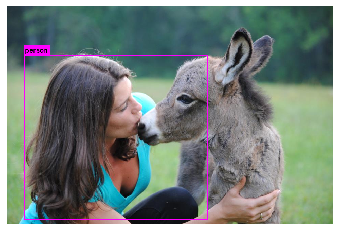

In [22]:

import os.path
import cv2
import matplotlib.pyplot as plt


fig,ax = plt.subplots()
ax.tick_params(labelbottom="off",bottom="off")
ax.tick_params(labelleft="off",left="off")
ax.set_xticklabels([]) 
ax.axis('off')

file = './predictions.png'
if os.path.exists(file):
  img = cv2.imread(file)
  show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
  plt.imshow(show_img)

# Drakent to Keras yolo v3

In [33]:
! python keras-yolo3/convert.py keras-yolo3/yolov3.cfg yolov3.weights keras-yolo3/model_data/yolo.h5



/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
Loading weights.
Weights Header:  0 2 0 [32013312]
Parsing Darknet config.
Creating Keras model.
Parsing section net_0
Parsing section convolutional_0
conv2d bn leaky (3, 3, 3, 32)
2018-06-16 16:42:23.233298: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:898] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-06-16 16:42:23.233842: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1356] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
totalMemory: 11.17GiB freeMemory: 10.80GiB
2018-06-16 16:42:23.23

Parsing section shortcut_13
Parsing section convolutional_33
conv2d bn leaky (1, 1, 512, 256)
Parsing section convolutional_34
conv2d bn leaky (3, 3, 256, 512)
Parsing section shortcut_14
Parsing section convolutional_35
conv2d bn leaky (1, 1, 512, 256)
Parsing section convolutional_36
conv2d bn leaky (3, 3, 256, 512)
Parsing section shortcut_15
Parsing section convolutional_37
conv2d bn leaky (1, 1, 512, 256)
Parsing section convolutional_38
conv2d bn leaky (3, 3, 256, 512)
Parsing section shortcut_16
Parsing section convolutional_39
conv2d bn leaky (1, 1, 512, 256)
Parsing section convolutional_40
conv2d bn leaky (3, 3, 256, 512)
Parsing section shortcut_17
Parsing section convolutional_41
conv2d bn leaky (1, 1, 512, 256)
Parsing section convolutional_42
conv2d bn leaky (3, 3, 256, 512)
Parsing section shortcut_18
Parsing section convolutional_43
conv2d bn leaky (3, 3, 512, 1024)
2018-06-16 16:42:50.159577: W tensorflow/core/framework/allocator.cc:101] Allocation of 18874368 exceeds 

Parsing section convolutional_71
conv2d bn leaky (3, 3, 128, 256)
Parsing section convolutional_72
conv2d bn leaky (1, 1, 256, 128)
Parsing section convolutional_73
conv2d bn leaky (3, 3, 128, 256)
Parsing section convolutional_74
conv2d    linear (1, 1, 256, 255)
Parsing section yolo_2
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 128         conv2d_1[0][0]                   
___________________

Saved Keras model to keras-yolo3/model_data/yolo.h5
Read 62001757 of 62001757.0 from Darknet weights.


In [39]:
# ! cp -R keras-yolo3/model_data .

! python  keras-yolo3/yolo.py ../sonkey13.jpeg

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
2018-06-16 16:48:11.559273: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:898] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-06-16 16:48:11.559731: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1356] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
totalMemory: 11.17GiB freeMemory: 10.80GiB
2018-06-16 16:48:11.559770: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1435] Adding visible gpu devices: 0
2018-06-16 16:48:11.942871: I tensorflow/core/common_runtime/gpu/gpu_device.cc:923] Devi

ModuleNotFoundError: ignored